This notebook is the main notebook for the project. Here, we create the model and train it to make appropriate predictions:

In [ ]:
import tensorflow as tf
import numpy as np
import keras_tuner as kt
from matplotlib import pyplot as plt

In [ ]:
# define relative paths
test_data_path = "../data/test"
train_data_path = "../data/train"
model_path = "../results/models"
metrics_path = "../results/metrics"
figures_path = "../results/figures"

In [ ]:
# Get train and test data as keras datasets:
img_size = 256
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
        train_data_path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        seed=123,
        labels="inferred")

test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_data_path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        color_mode='grayscale',
        seed=123,
        labels="inferred")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


We perform hyperparameter tuning to optimize our model. The hyperparameters we tune are the number of neurons in each of the 4 layers, as well as the size of the kernel in our 3 convolution layers. Our metrics are a combination of accuracy and recall. 

We chose to use **Recall** because this dataset is medical in nature. Pnemonia is a dangerous condition especially in elderly patients. We feel it is much better to incorrectly identify someone as having pneumonia than to fail to identify a true positive case. The recall metric allows us to minimize false negatives.

In [ ]:
# Define a model_builder function to use in hyperparameter tuning
def model_builder(hp):
    model = tf.keras.Sequential()
    size_1 = hp.Choice("Layer 1 Size", values=[16, 32, 64])
    kernel_1 = hp.Choice("Kernel 1 Size", values=[2, 3])
    model.add(tf.keras.layers.Conv2D(size_1, kernel_1, activation="relu", input_shape=(img_size, img_size, 1)))
    model.add(tf.keras.layers.MaxPooling2D())

    size_2 = hp.Choice("Layer 2 Size", values=[16, 32, 64])
    kernel_2 = hp.Choice("Kernel 2 Size", values=[2, 3])
    model.add(tf.keras.layers.Conv2D(size_2, kernel_2, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())

    size_3 = hp.Choice("Layer 3 Size", values=[16, 32, 64])
    kernel_3 = hp.Choice("Kernel 3 Size", values=[2, 3])
    model.add(tf.keras.layers.Conv2D(size_3, kernel_3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D())
    
    model.add(tf.keras.layers.Flatten())
    size_4 = hp.Choice("Layer 4 Size", values=[16, 32, 64])
    model.add(tf.keras.layers.Dense(size_4, activation="relu"))
    # model.add(Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', "recall"])
    
    return model

In [ ]:
# Perform hyperparameter tuning:
tuner = kt.Hyperband(model_builder,
                     objective= ['val_accuracy', "val_recall"],
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
tuner.search(train_data, epochs=50, callbacks=[stop_early], validation_data=test_data)

Trial 30 Complete [00h 01m 18s]
multi_objective: -1.796794831752777

Best multi_objective So Far: -1.8355768918991089
Total elapsed time: 00h 21m 50s


'history = model.fit(\n        train_data,\n        epochs=10,\n        validation_data=test_data)\n\n# precisionatrecall\n# f1 score'

From this, we take the model with the best hyperparameters and train it for a relatively long time to see what the optimal training time is:

In [ ]:
# Get the optimal hyperparameters:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal hyperparameters: ", best_hps.values)
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_data,
    epochs=15,
    validation_data = test_data)

Optimal hyperparameters:  {'Layer 1 Size': 32, 'Kernel 1 Size': 2, 'Layer 2 Size': 64, 'Kernel 2 Size': 3, 'Layer 3 Size': 32, 'Kernel 3 Size': 2, 'Layer 4 Size': 32, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.7840 - loss: 4.1519 - recall: 0.8350 - val_accuracy: 0.7500 - val_loss: 0.7733 - val_recall: 0.9846
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.9636 - loss: 0.1037 - recall: 0.9752 - val_accuracy: 0.7228 - val_loss: 0.8830 - val_recall: 0.9795
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.9499 - loss: 0.1308 - recall: 0.9646 - val_accuracy: 0.6891 - val_loss: 1.9706 - val_recall: 0.9974
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9754 - loss: 0.0783 - recall: 0.9846 - val_accuracy: 0.7276 - val_loss: 1.2968 - val_recall: 0.9974
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9873 - los

We plot these metrics over time to find the optimal number of epochs to train for. After analyzing the model training history we can make appropriate decisions on how to proceed with optimizing the training of the model. See next markdown for analysis of the training history.

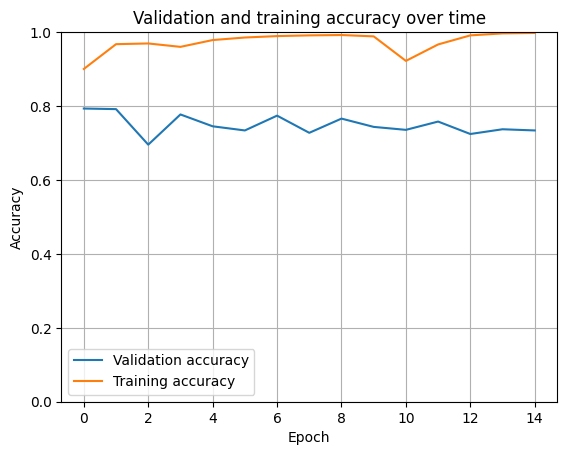

In [ ]:
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.legend(loc="best")
plt.grid()
plt.title("Validation and training accuracy over time")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.savefig(metrics_path+"/accuracy.png")
plt.show()

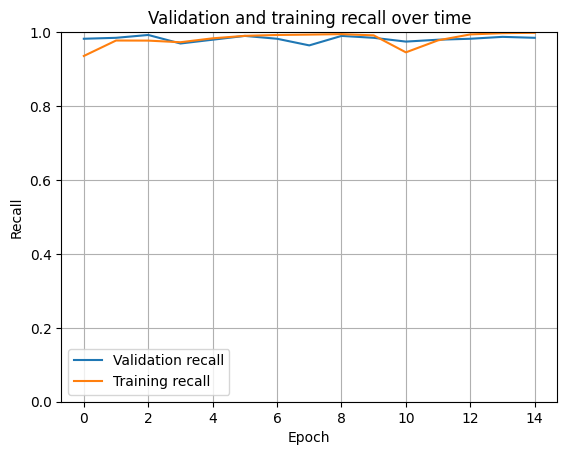

In [ ]:
plt.plot(history.history["val_recall"], label="Validation recall")
plt.plot(history.history["recall"], label="Training recall")
plt.legend(loc="best")
plt.grid()
plt.title("Validation and training recall over time")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.savefig(metrics_path+"/recall.png")
plt.show()

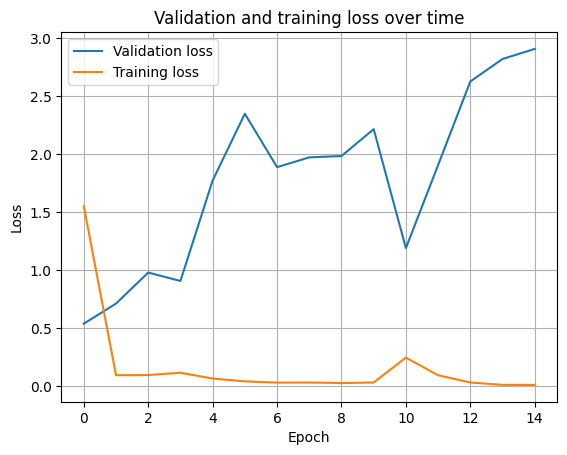

In [ ]:
plt.plot(history.history["val_loss"], label="Validation loss")
plt.plot(history.history["loss"], label="Training loss")
plt.legend(loc="best")
plt.grid()
plt.title("Validation and training loss over time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(metrics_path+"/loss.png")
plt.show()

From the above training, we see that 6 epochs is the optimal training time because it has optimal accuracy and recall and acceptable loss without taking excessively long to train, so we train our final model for that long. We recognize that training the model for 10 epochs would minimize loss, however, in the intrest of optimizing speed, recall, and accuracy, we choose to train for 6 epochs.

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_data,
    epochs=6,
    validation_data = test_data)

Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.8397 - loss: 6.0618 - recall: 0.8882 - val_accuracy: 0.6891 - val_loss: 1.1962 - val_recall: 1.0000
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9436 - loss: 0.1672 - recall: 0.9604 - val_accuracy: 0.7837 - val_loss: 0.7884 - val_recall: 0.9667
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.9572 - loss: 0.1176 - recall: 0.9704 - val_accuracy: 0.6907 - val_loss: 1.9071 - val_recall: 0.9949
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9757 - loss: 0.0719 - recall: 0.9827 - val_accuracy: 0.7788 - val_loss: 0.9786 - val_recall: 0.9872
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.9728 - loss: 0.0661 - recall: 0.9751 - val_accuracy: 0.7131 - val_loss: 1.6985 - val_recall: 0.9923
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.9904 - loss: 0.0267 - recall: 0.9935 - val_accuracy: 0.7500 - val_loss: 1.4605 - val_recall: 0.982

Finally, we save our model for future use:

In [ ]:
model.save(model_path + '/model_saved.keras')

We also saved a schamatic of our final model which can be viewed in the figures folder:

In [ ]:
tf.keras.utils.plot_model(model, to_file=figures_path+'/model_diagram.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)